Candidate Generation and LUNA16 prep...

In this kernel, I will be talking about the methods that will help in better understanding of the problem statement and visualisation of the data. I will also provide links of useful resources and information. 
The script is written in Python. I recommend people to install anaconda on their desktop because of its advantages mentioned here. The libraries that wil be use in this tutorial for reading, processing and visualization of data are matplotlib, numpy, skimage and pydicom. 
The images are of size (z,512,512) where z is the number of slices in the CT scan and varies depending on the resolution of the scanner. Such large images cant be fed directly into a Convolution Network architecture because of the limit on the computation power. thus we will have to find the regions that are more probable of having cancer. We will be reduing our search space by first segmenting the lungs and then removing the low intensity regions. 

In this totorial, we will first start with reading the dataset and visualizing it. After that, we will be segmenting the lung structures and then find the region of interest (possible cancer regions) in the CT Scans using Image processing methods. Thin I will talk about how to preprocess LUNA16 dataset for training architectures like UNet for segmentation and candidate classification. 

The segmentation of lung structures is very challenging problem because homogeneity is not present in the lung region, similar densities in the pulmonary structures, different scanners and scanning protocols. The segmented lungs can be further used to find the lung nodule candidates and regions of interest which may help in better classification of the CT Scans. Finding the lung nodule regions is a very hard problem because there are nodules that are attached to the blood vessels or present at the boundary of the lung region. The lung nodule candidates can be further used for classification by cutting 3D voxels around them and passing it through a 3D CNNs which can be trained on LUNA16 dataset. The LUNA 16 dataset has the location of the nodules in each CT Scan thus will be useful for training the classifier. 


In [6]:
%matplotlib inline 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

Each 3D CT Scan consists of many slices, whose number depends on the resolution of the scanner and each slice has a Instance Number associated with it which tells the index of the slice from the top. All the dicom files for a CT Scan are inside one folder having the CT Scan's name. Now we will read all the dicom slices for a scan and then stack the with respect to their instance Number to get the 3D Lung CT Scanned Image. 
The sample_images folder has around 20 folders each corresponding to one CT Scan. Inside the folder there are many dicom files

In [4]:
from subprocess import check_output
print(check_output(["ls", "sample_images"]).decode("utf8"))

00cba091fa4ad62cc3200a657aeb957e
0a099f2549429d29b32f349e95fb2244
0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
0acbebb8d463b4b9ca88cf38431aac69
0b20184e0cd497028bdd155d9fb42dc9
0bd0e3056cbf23a1cb7f0f0b18446068
0c0de3749d4fe175b7a5098b060982a1
0c37613214faddf8701ca41e6d43f56e
0c59313f52304e25d5a7dcf9877633b1
0c60f4b87afcb3e2dfa65abbbf3ef2f9
0c98fcb55e3f36d0c2b6507f62f4c5f1
0c9d8314f9c69840e25febabb1229fa4
0ca943d821204ceb089510f836a367fd
0d06d764d3c07572074d468b4cff954f
0d19f1c627df49eb223771c28548350e
0d2fcf787026fece4e57be167d079383
0d941a3ad6c889ac451caf89c46cb92a
0ddeb08e9c97227853422bd71a2a695e
0de72529c30fe642bc60dcb75c87f6bd



Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values of ~2000 with 0 because they are the pixels that fall outside of the scanner bounds.

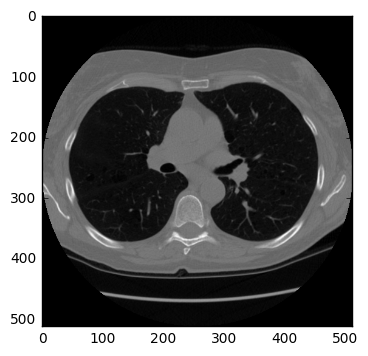

In [26]:
# Any results you write to the current directory are saved as output.
lung = dicom.read_file('sample_images/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

In [8]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices


In [9]:
ct_scan = read_ct_scan('sample_images/00cba091fa4ad62cc3200a657aeb957e/') 

To visualise the slices, we will have to plot them. matplotlib is used for plotting the slices. The plot_ct_scan function takes a 3D CT Scanned image array as input and plots equally spaced slices. The CT Scans are grayscale images i.e. the value of each pixel is a single sample, which means it carries only intensity information.

In [10]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

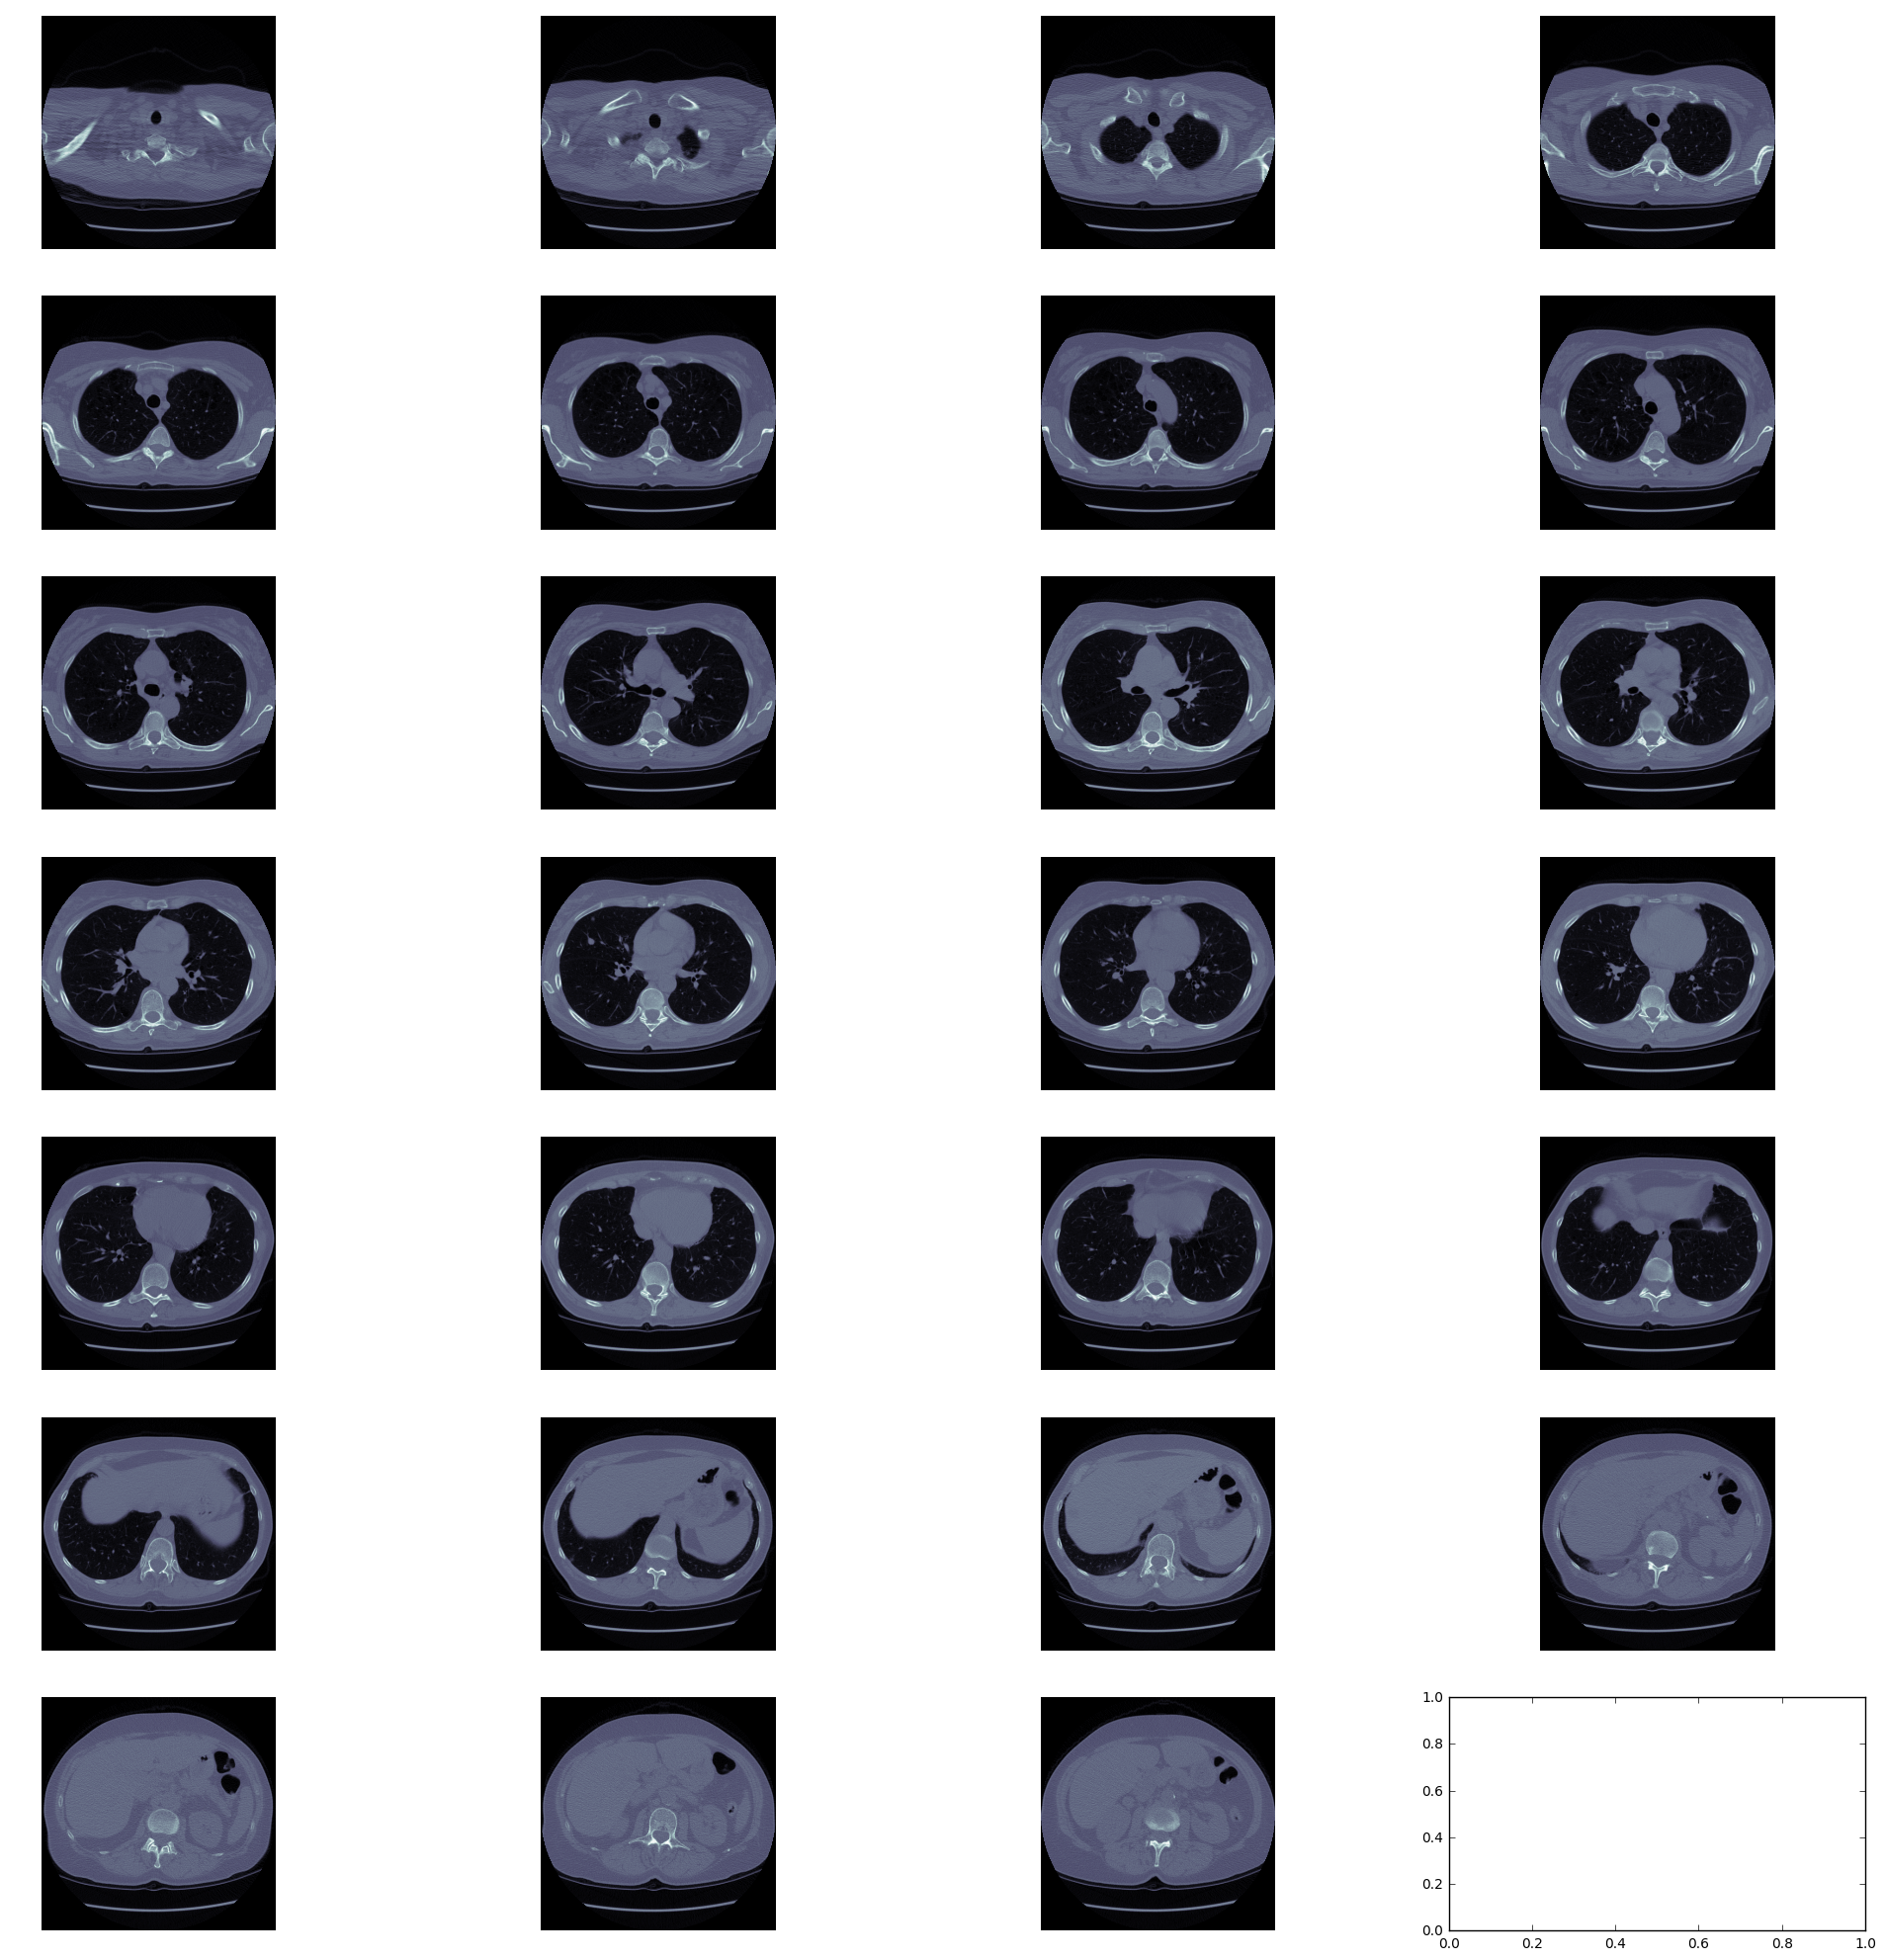

In [11]:
plot_ct_scan(ct_scan)

Segmentation of Lungs
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs ae the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. 

In [12]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

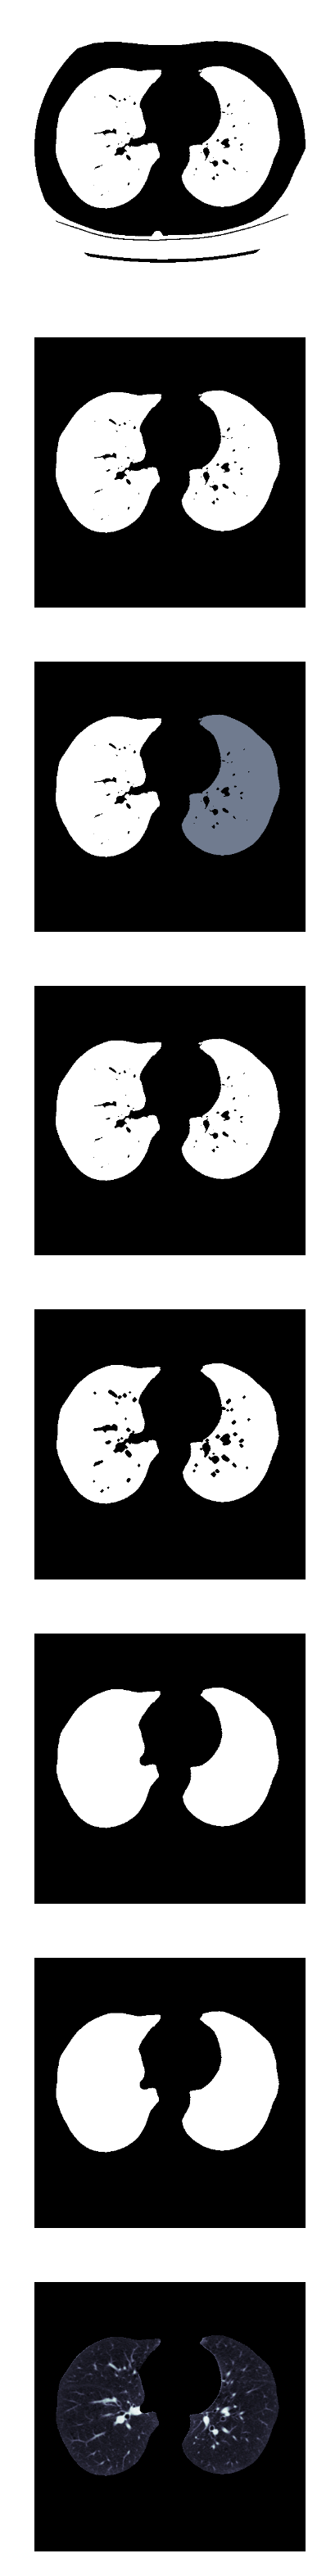

In [13]:
get_segmented_lungs(ct_scan[71], True)

In [14]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

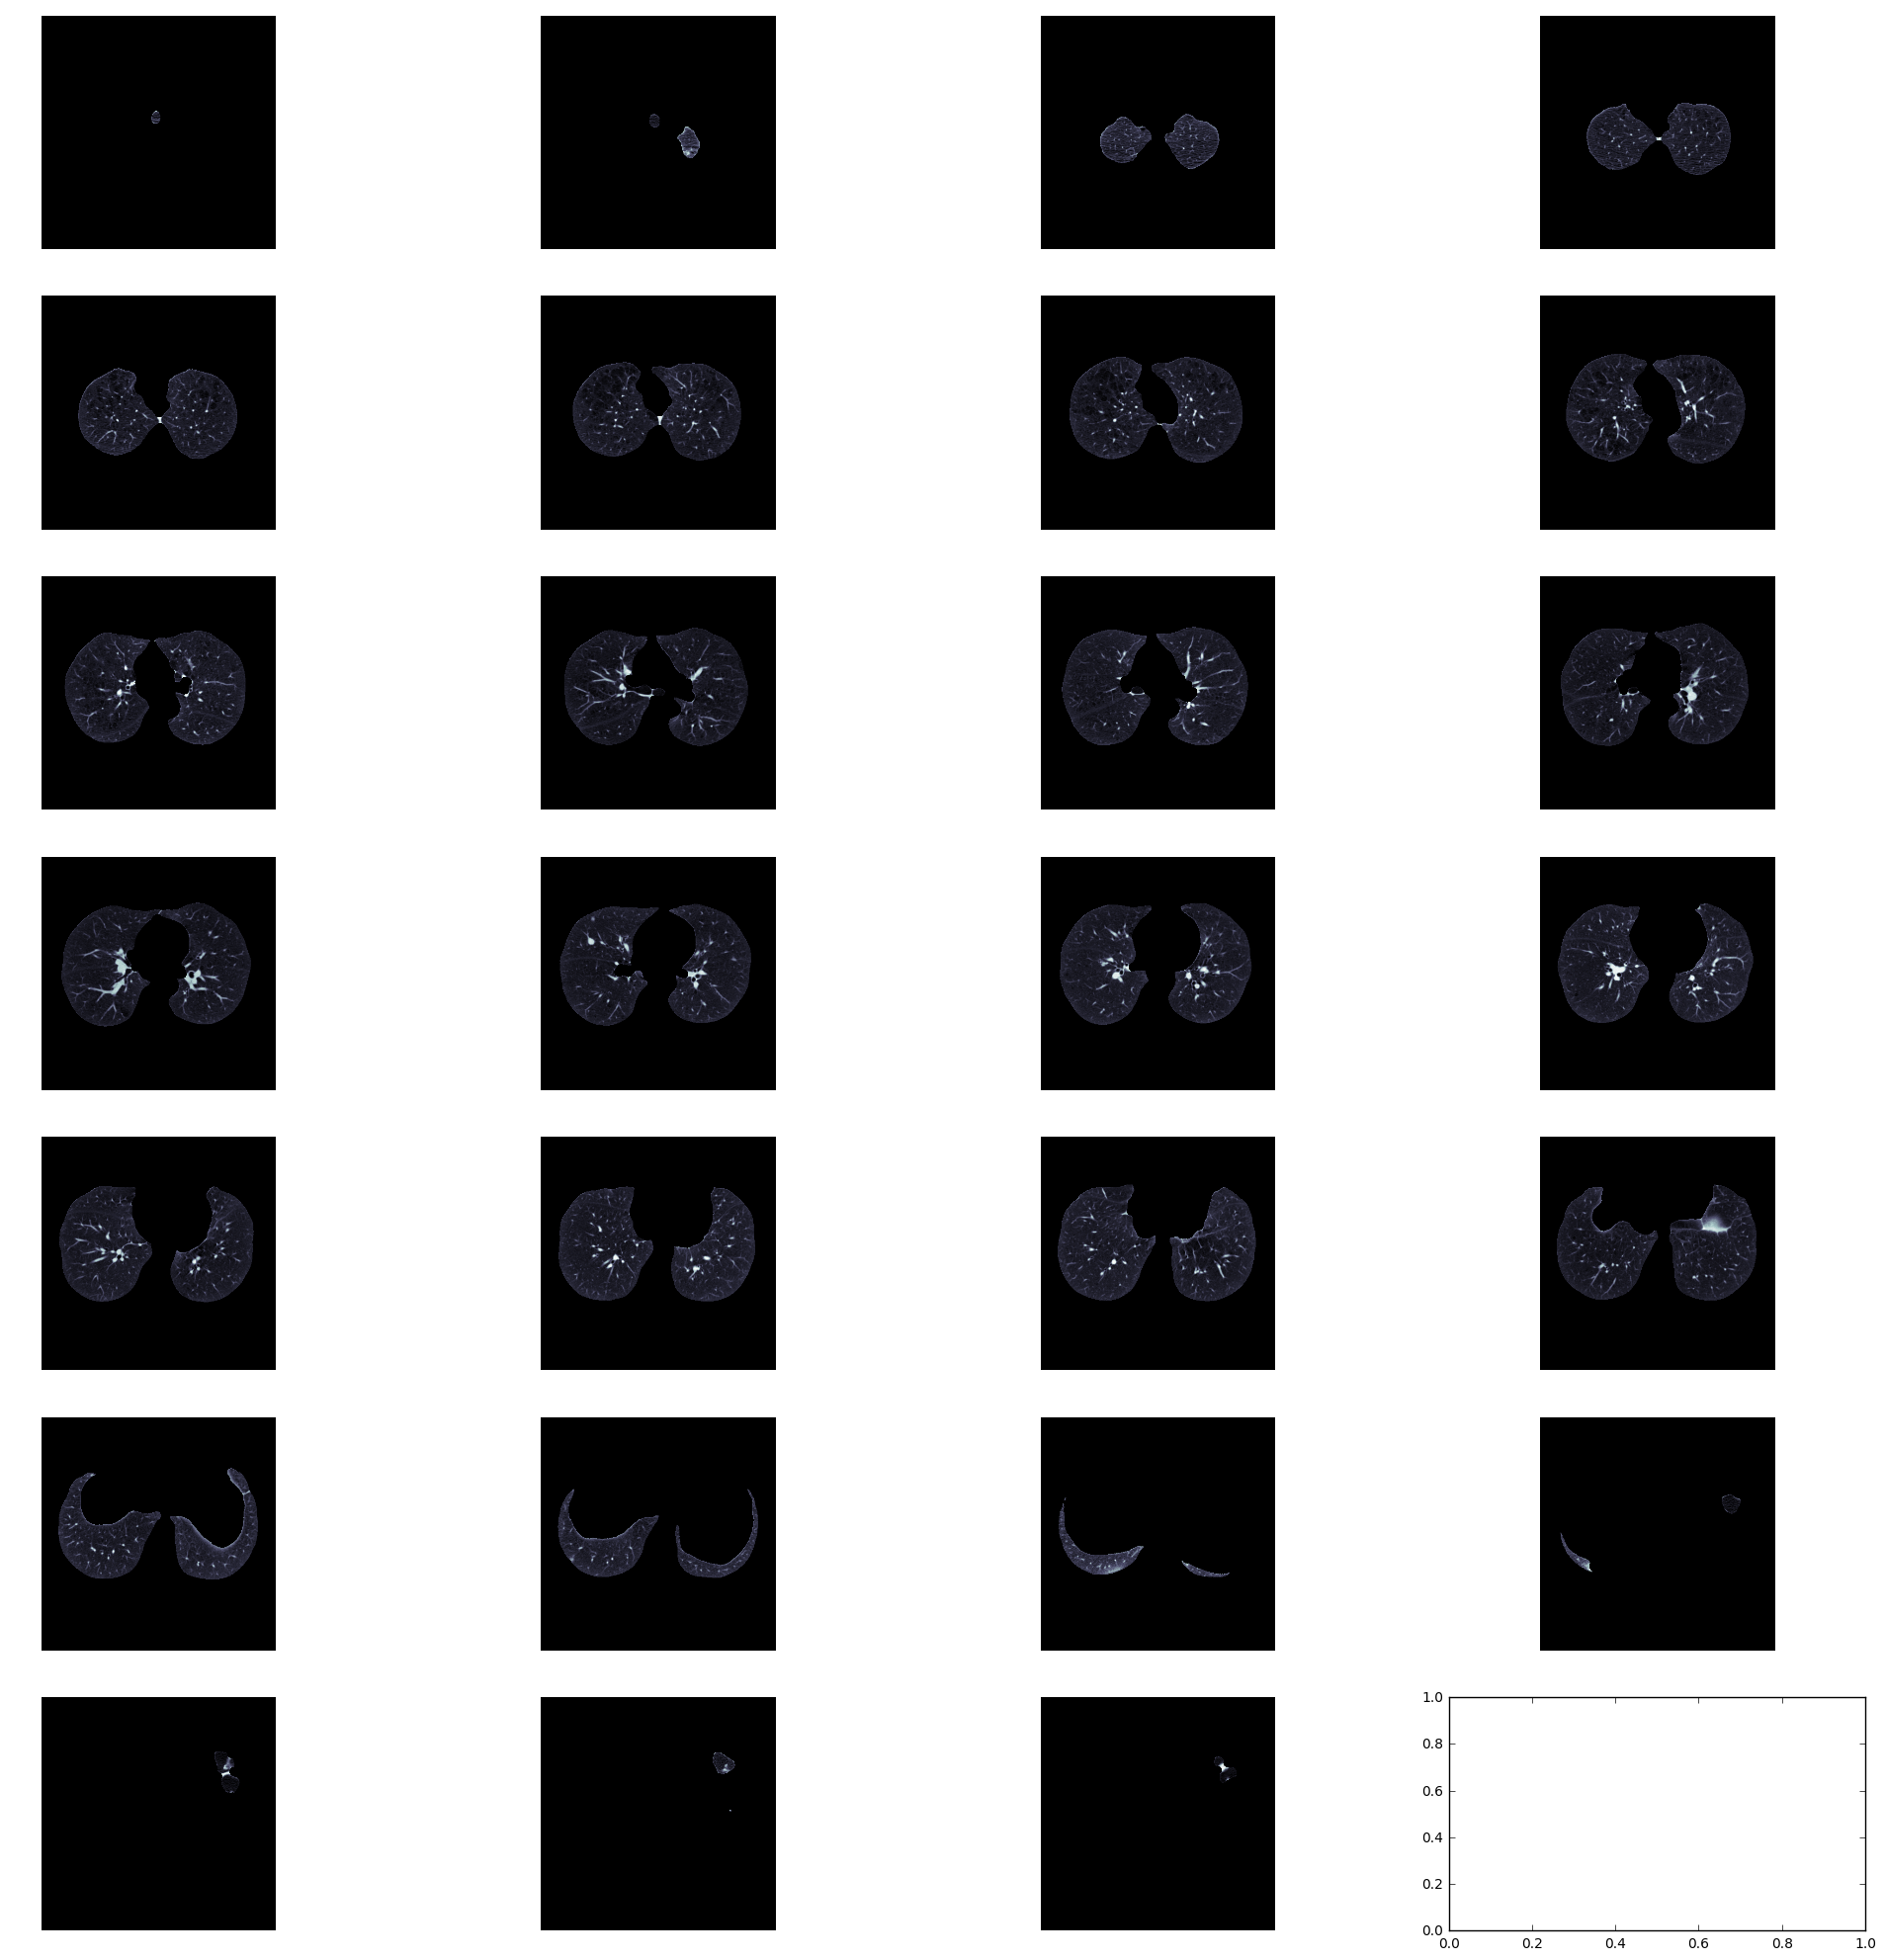

In [15]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

Nodule Candidate/Region of Interest Generation
After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules since the search space is very large. Also, whole image cann't be classified directly using 3D CNNs due to limit on computation, we need to find possible regions of cancer and then classify them. It was found in experiments that all the region of interests have intensity > 604(-400 HU). So, we used this threshold to filter the darker regions. This reduces the number of candidates by a large number and preserves all the important regions with high recall. We then classify all the candidate points to reduce the False Posititives.

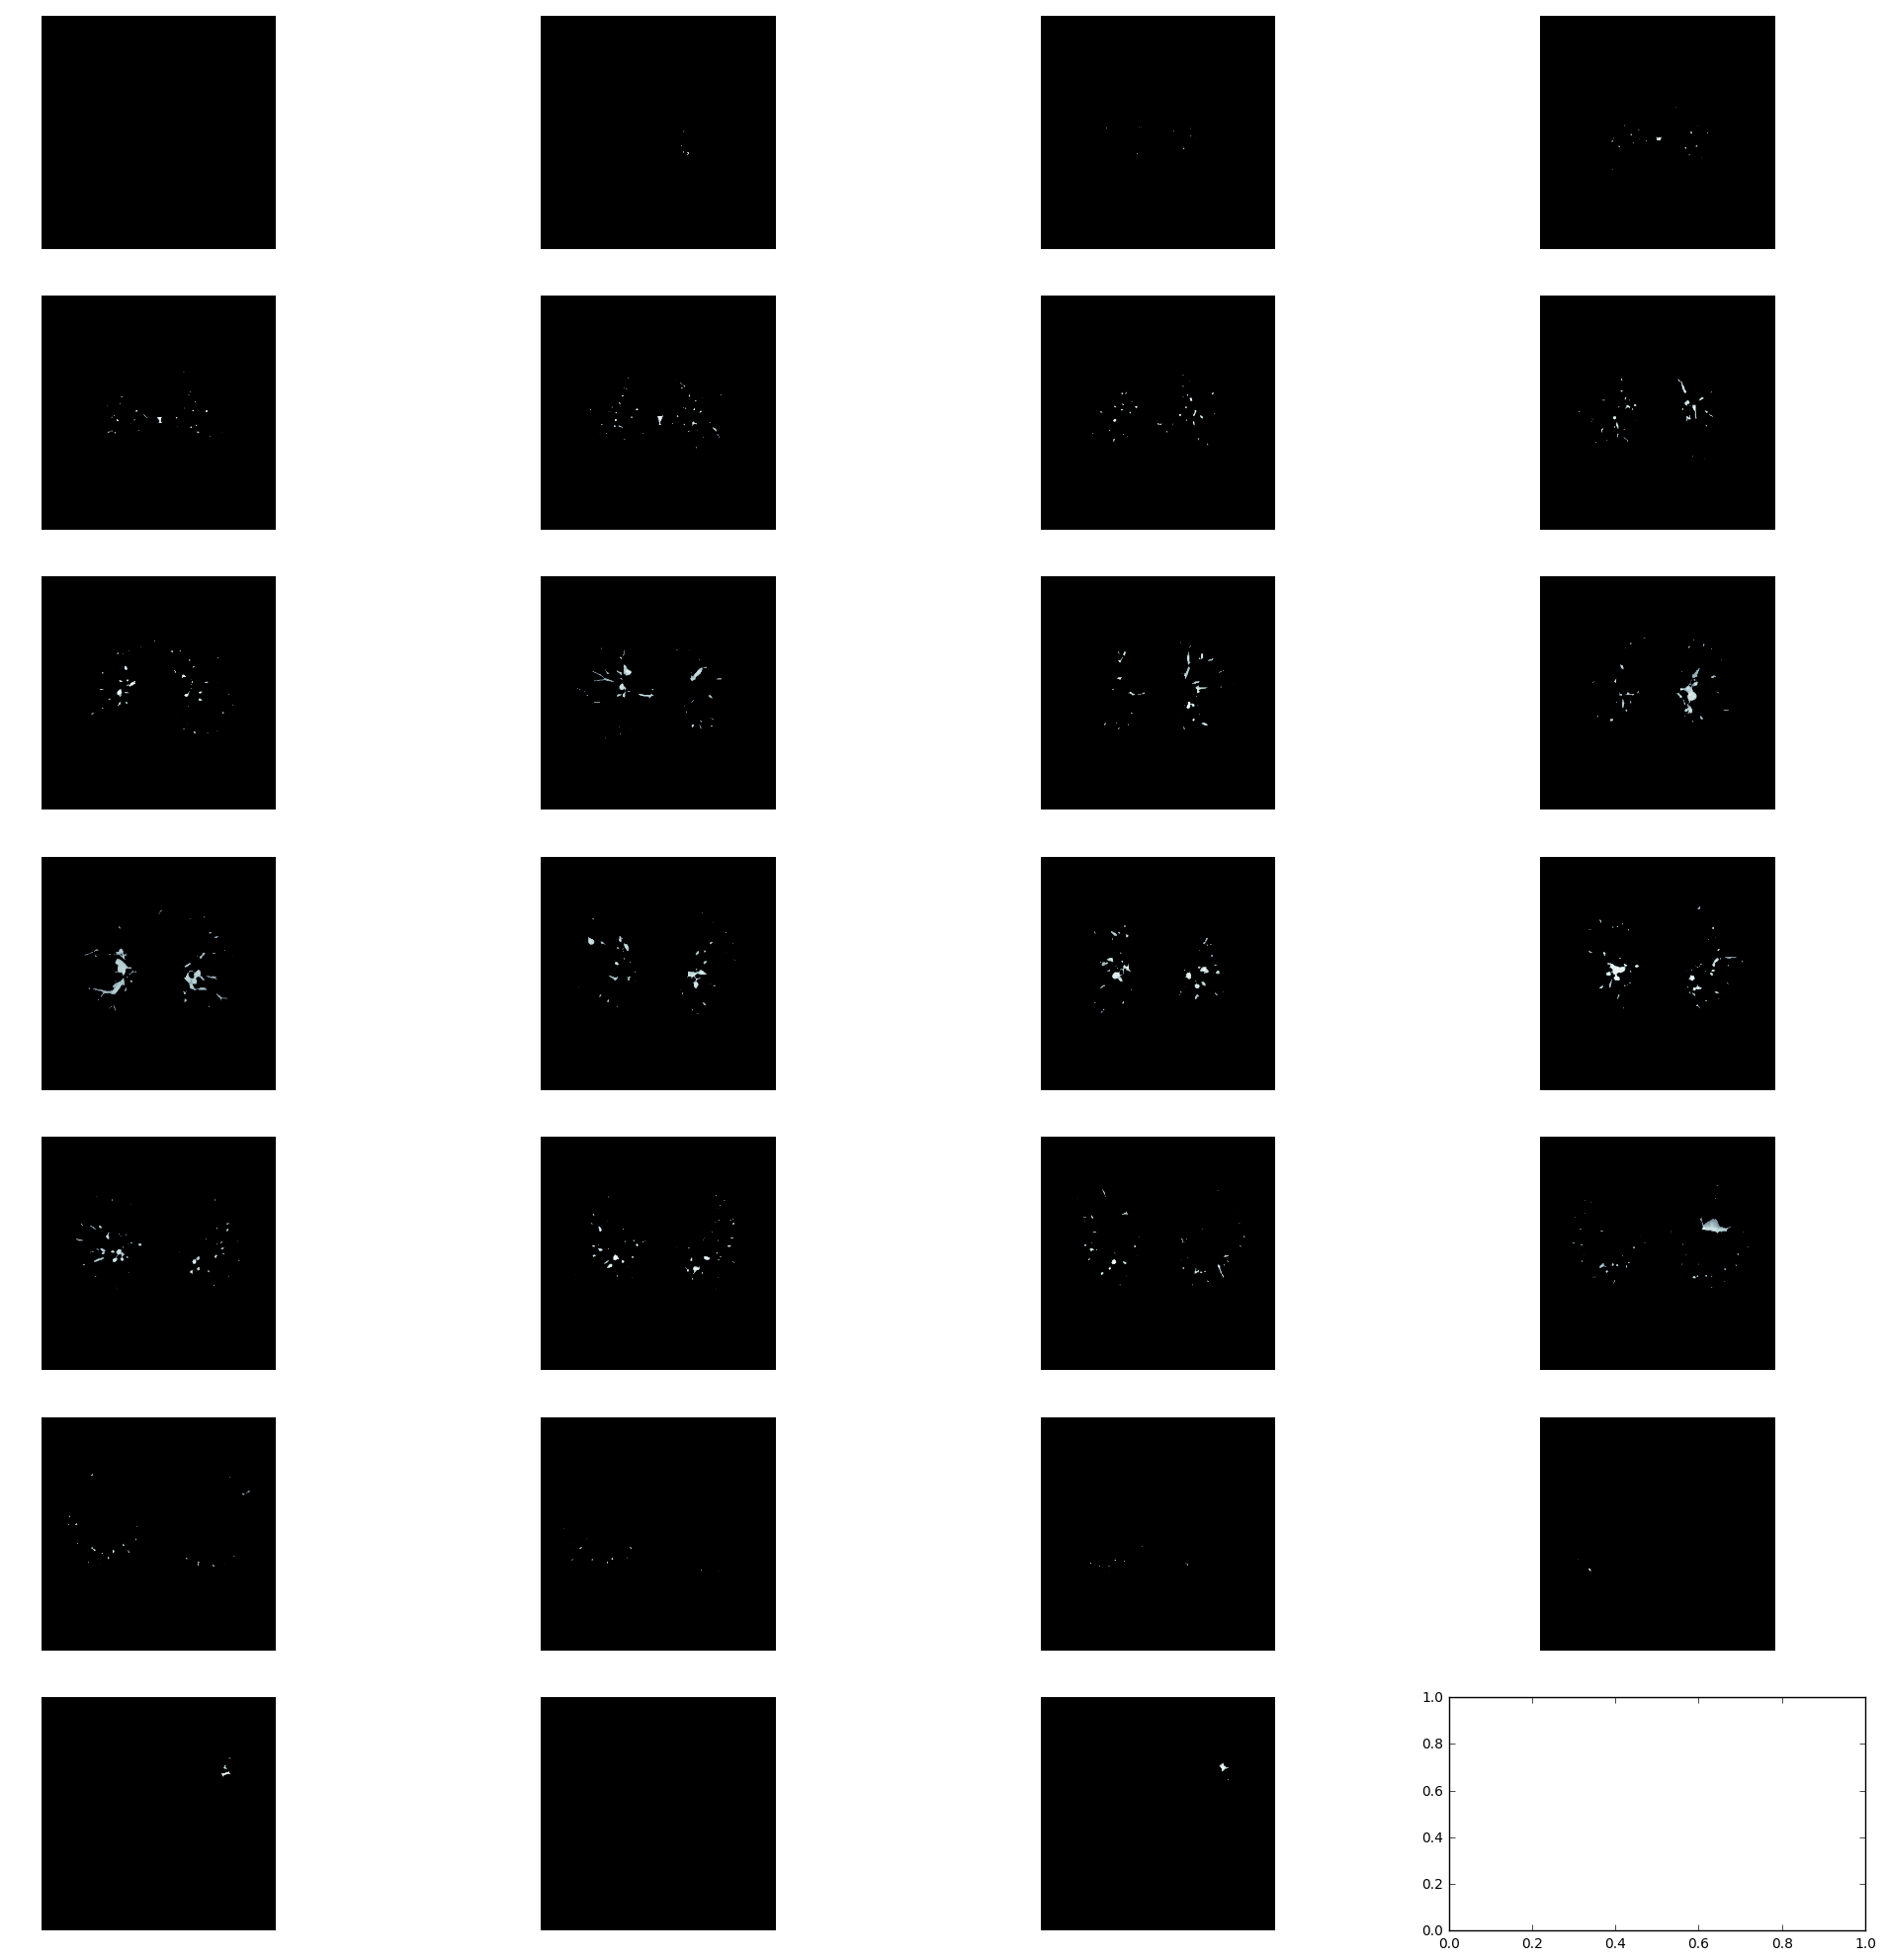

In [16]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

In [17]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [18]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

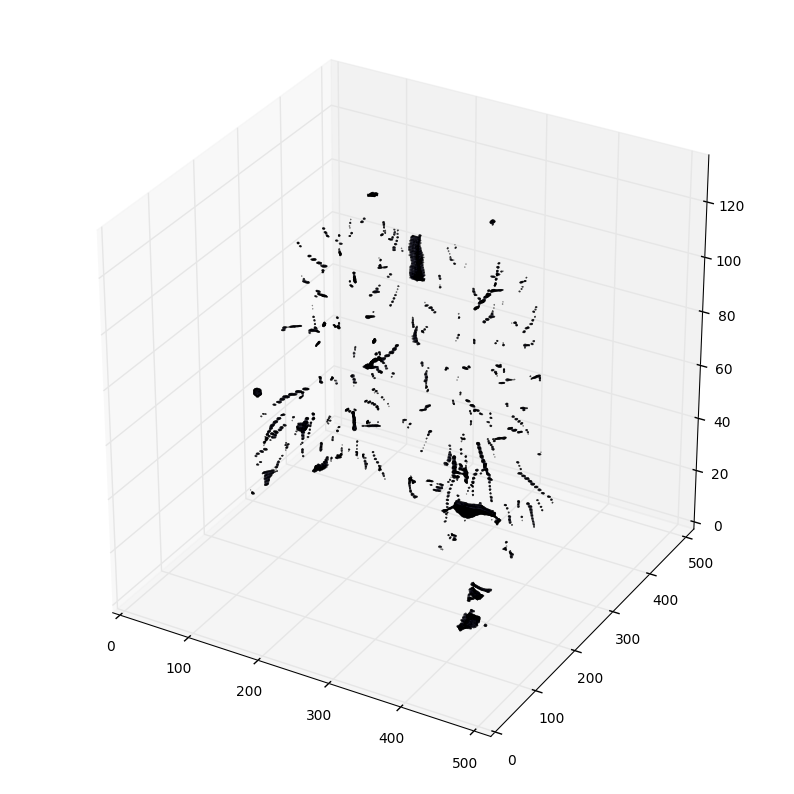

In [19]:
plot_3d(segmented_ct_scan, 604)